# This assignment provides hands-on data wrangling and classification experience
For this assignment, you are a Machine Learning Engineer at a local bank, and your task is to analyze whether loan applicants qualify, based on their personal information.
Tasks are:
I. Data wrangling to perform one-hot-encoding for the data and normalization
II. Eliminating unimportant features
III. Performing classification to predict qualification for loan in future.

### Import the necessary modules

In [171]:
import os
import tensorflow as tf
#from tensorflow.contrib.tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix

### Load the training data. Print out its shape and first few rows.

In [71]:
url = "https://raw.githubusercontent.com/FourthBrain/2.-Classification/main/bank-full.csv?token=ARJV76TWTYENKFZKXB4CUYS7SIDOM"
df = pd.read_csv(url, sep=';')
print(np.shape(df))
df.head()


(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Exercise: Perform Exploratory Data Analysis on each feature

In [72]:
### START CODE HERE ###
# Get the info (column number and name, non-null count, and dtype) for each column in the training df
print(df.info())
# Get summary statistics for the training df with the describe() method
print(df.describe())
### END CODE HERE ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
                age        balance           day      duration      campaign  \
count  45211.0

### Exercise: Visualize the distributions of each numeric feature

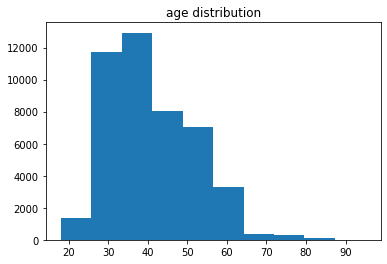

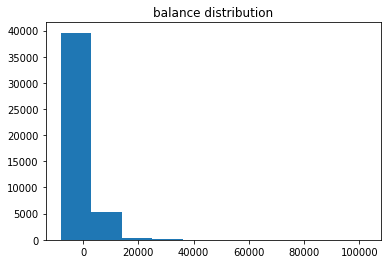

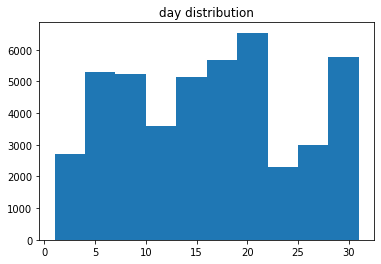

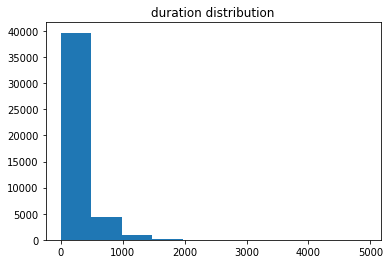

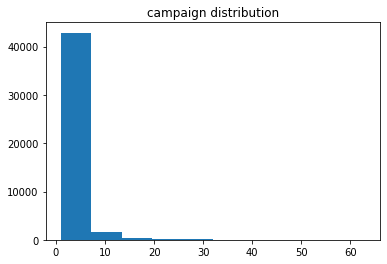

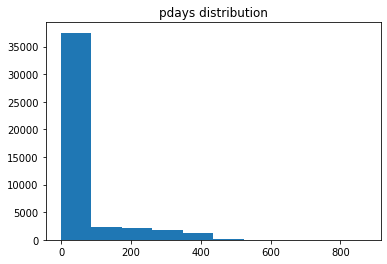

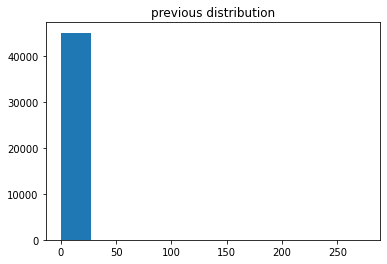

In [73]:
### START CODE HERE ###
# Use a list comprehension to extract the names of the numeric columns of the training df 
# (those with an integer dtype)
numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.integer)]
# Loop through the numeric columns
for col in numeric_columns:
    # Generate a histogram of the current numeric feature column
    plt.hist(df[col])
    plt.title(f'{col} distribution')
    plt.show()

### Exercise: Inspect the unique values of the non-numeric columns, and their counts

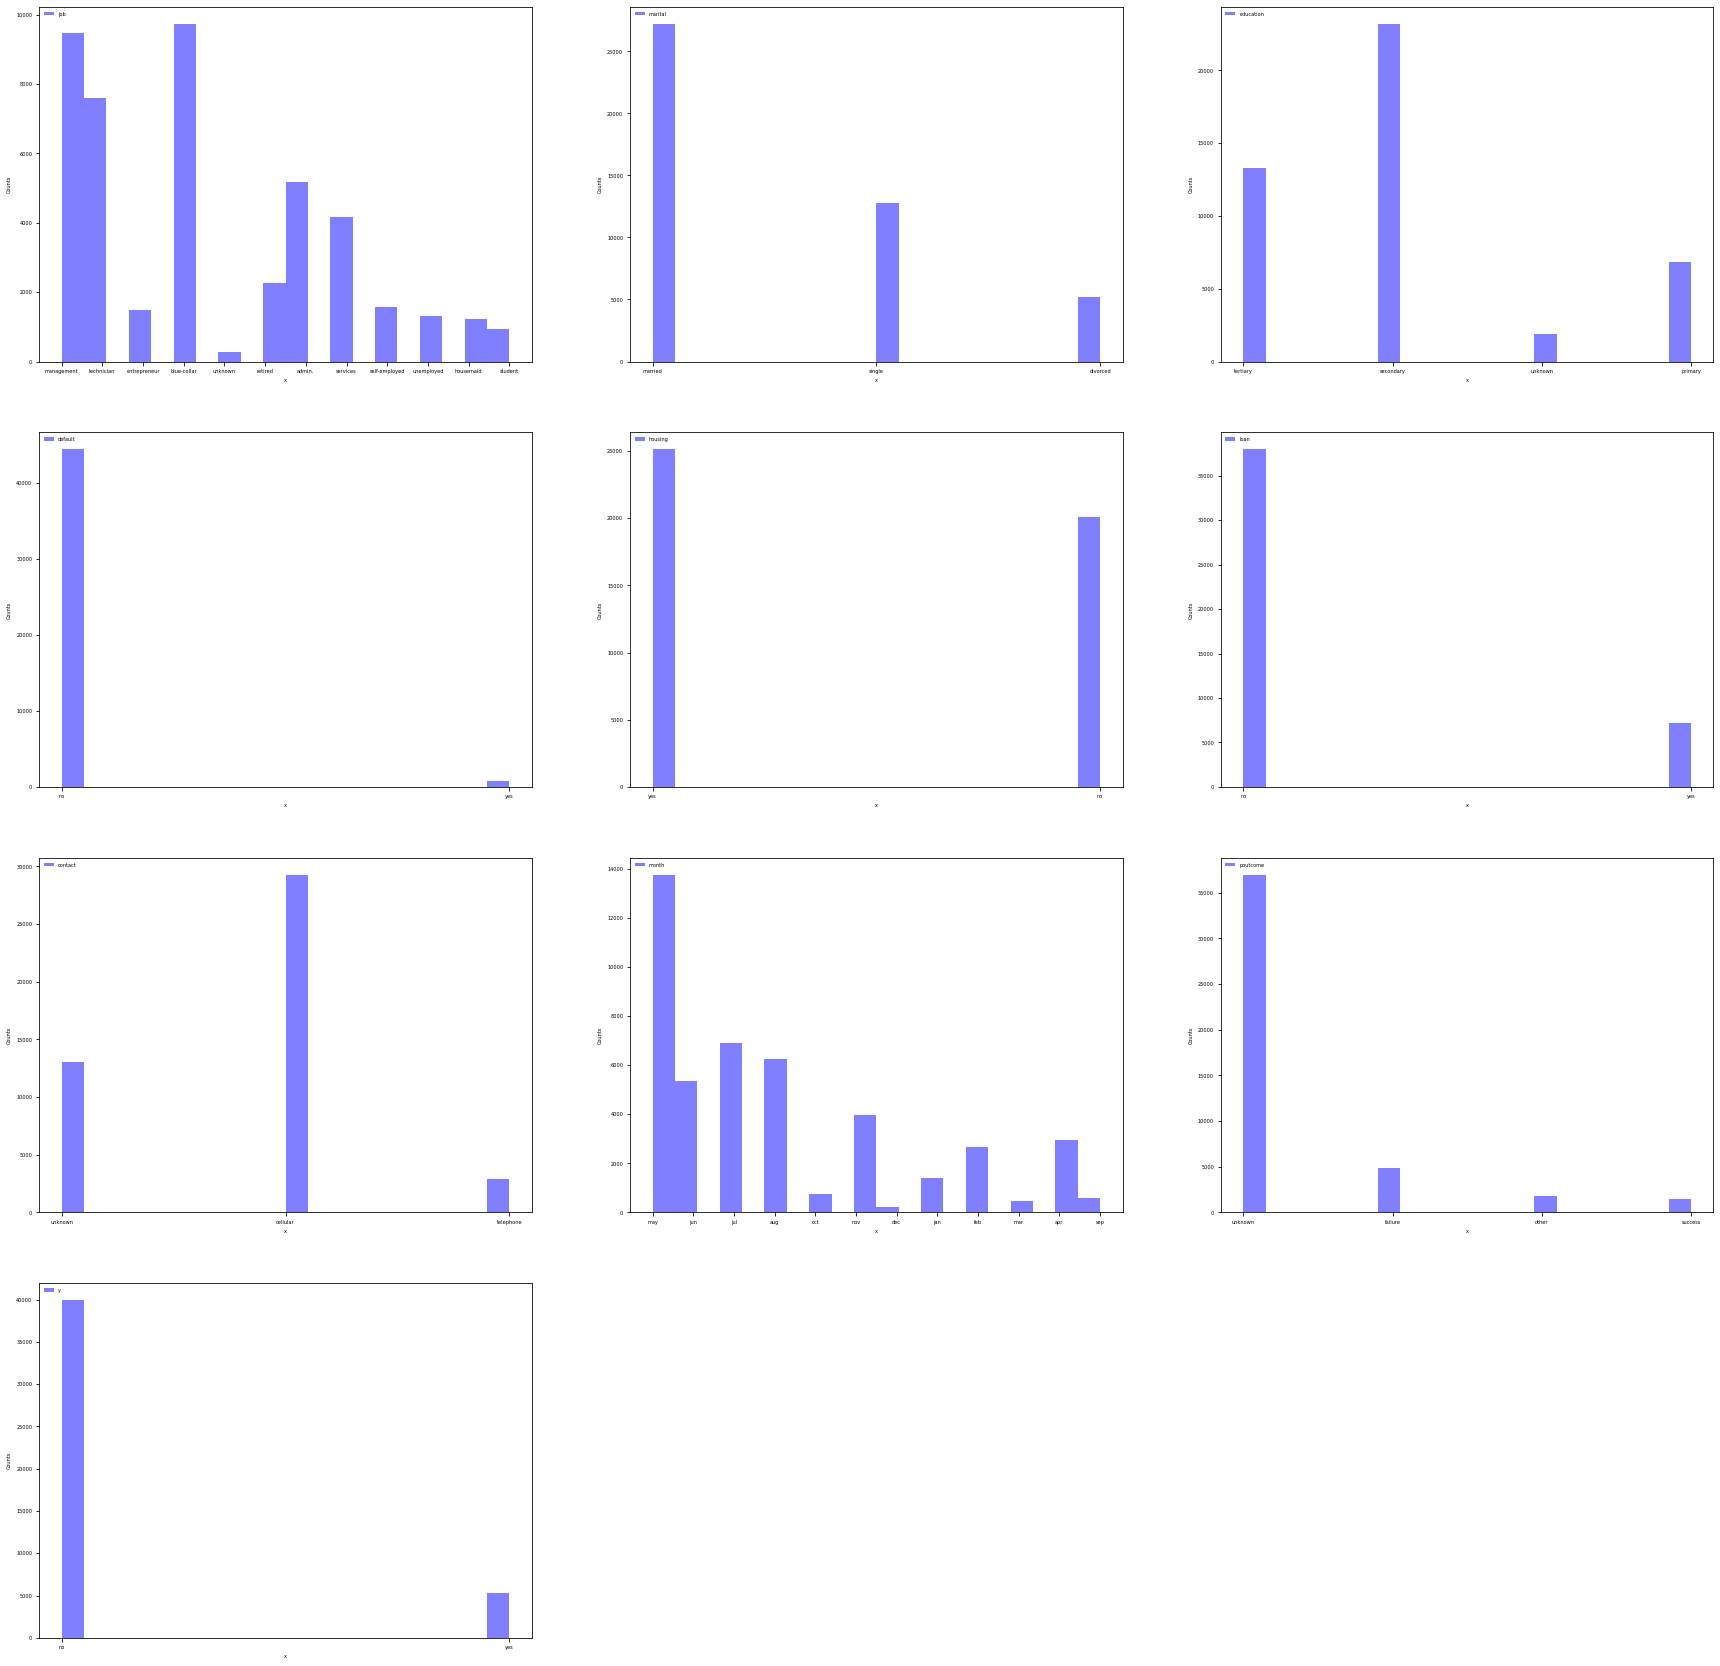

In [74]:
### START CODE HERE ###
# Use a list comprehension to list the names of the non-numeric columns in the training df
# (those with an object dtype)
non_numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.object)]

# Generically define how many plots along and across
ncols = 3
nrows = int(np.ceil(len(non_numeric_columns) / (1.0*ncols)))
plt.rc('font', size=5) 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(non_numeric_columns):

            ax.hist(df[non_numeric_columns[counter]], bins=20, color='blue', alpha=0.5, label='{}'.format(non_numeric_columns[counter]))
            ax.set_xlabel('x')
            ax.set_ylabel('Counts')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

In [75]:
for col in non_numeric_columns:
    print(col, df[col].value_counts().to_dict())

job {'blue-collar': 9732, 'management': 9458, 'technician': 7597, 'admin.': 5171, 'services': 4154, 'retired': 2264, 'self-employed': 1579, 'entrepreneur': 1487, 'unemployed': 1303, 'housemaid': 1240, 'student': 938, 'unknown': 288}
marital {'married': 27214, 'single': 12790, 'divorced': 5207}
education {'secondary': 23202, 'tertiary': 13301, 'primary': 6851, 'unknown': 1857}
default {'no': 44396, 'yes': 815}
housing {'yes': 25130, 'no': 20081}
loan {'no': 37967, 'yes': 7244}
contact {'cellular': 29285, 'unknown': 13020, 'telephone': 2906}
month {'may': 13766, 'jul': 6895, 'aug': 6247, 'jun': 5341, 'nov': 3970, 'apr': 2932, 'feb': 2649, 'jan': 1403, 'oct': 738, 'sep': 579, 'mar': 477, 'dec': 214}
poutcome {'unknown': 36959, 'failure': 4901, 'other': 1840, 'success': 1511}
y {'no': 39922, 'yes': 5289}


In [128]:
import calendar


def is_yes_no(df, col):
    return all(q in df[col].unique() for q in ('yes', 'no'))

def map_binary_to_integers(df, binary_columns, binary_mapping={'yes': 1, 'no': 0}):
    # Map the binary columns
    df = df.copy()
    df[binary_columns] = df[binary_columns].applymap(lambda yn: binary_mapping[yn])
    return df

def map_months_to_integers(df, month_column, month_mapping={calendar.month_abbr[i].lower(): i for i in range(1, 13)}):
    df = df.copy()
    df[month_column] = df[month_column].apply(lambda ms: month_mapping[ms.lower()])
    return df      

def get_non_numeric_columns(df):
    return [col for col in df.columns if np.issubdtype(df[col].dtype, np.object)]

def one_hot_encode_categoricals(df):
    non_numeric_columns = get_non_numeric_columns(df)
    assert len(non_numeric_columns) == 5
    df = df.copy()
    categorical_columns = pd.get_dummies(df[non_numeric_columns])
    df = df.drop(columns=non_numeric_columns)
    df = pd.merge(df, categorical_columns, left_index=True, right_index=True)
    return df

def transform(df):
    # Make a list of the binary columns. There should be 4 of them. 
    # Find their names in the output of the previous exercise.
    df = df.copy()
    non_numeric_columns = get_non_numeric_columns(df)
    
    binary_columns = [col for col in non_numeric_columns if is_yes_no(df, col)]
    assert len(binary_columns) == 4
    
    df = map_binary_to_integers(df, binary_columns)
    df = map_months_to_integers(df, month_column="month")
    df = one_hot_encode_categoricals(df)   
    
    # Extract the target values from the training DataFrame
    y = df["y"].values
    # Drop the target column from the training DataFrame
    X = df.drop(columns=["y"])
    return X, y
    

In [130]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [131]:
X, y = transform(df); X.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,...,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,...,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,...,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,...,0,0,1,0,0,1,0,0,0,1


### Exercise: Inspect how balanced y is

For a balanced binary target, approximately half of its entries will be 1

In [133]:
print("Percent positive", np.sum(y) / len(y))

Percent positive 0.11698480458295547


### Print the current number of features

In [134]:
print(f'The training df currently has {X.shape[1]} features')

The training df currently has 37 features


### Exercise: Visually inspect the Pearson Correlations of each feature

Pandas provides the `corr()` method for DataFrames for this purpose

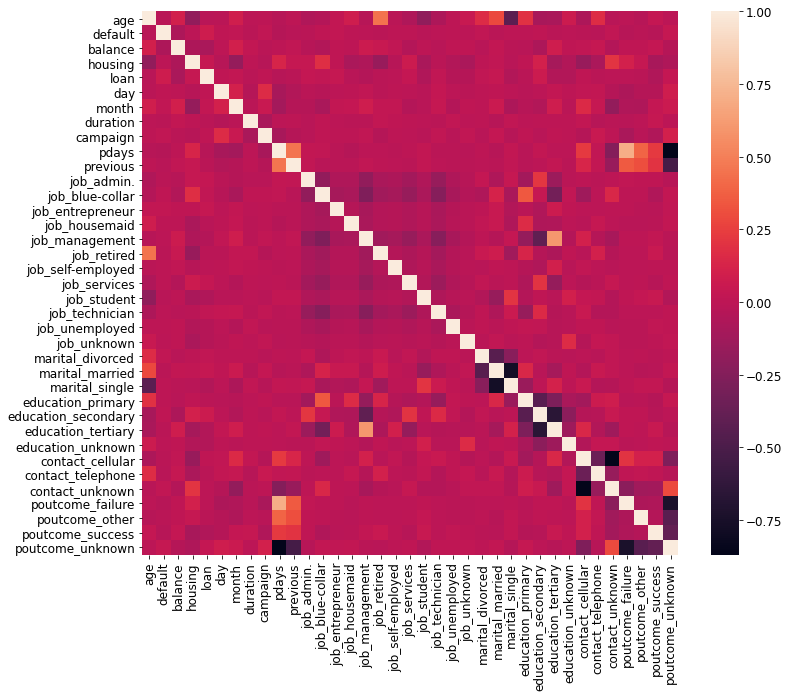

In [136]:
plt.rc('font', size=12) 
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = X.corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

## Feature Selection

### Exercise: Drop feature columns which have a high absolute Pearson Correlation

Let's choose to drop the higher-indexed of the two correlated columns, i.e. the one that appears farther to the right in the df

In [142]:
### START CODE HERE ### 
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = {c: True for c in X.columns}
# Loop over all columns
for i in range(len(X.columns)):
    # Loop over all columns to the right of the current one
    for j in range(i+1, len(X.columns)):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8...
        if cor[X.columns[i]][X.columns[j]] >= 0.8:
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[X.columns[j]]:
                # Drop column j
                keep_columns[X.columns[j]] = False

# Extract the columns to keep from the training df
selected_columns = [c for c in keep_columns if keep_columns[c]]
# Make a new df with the columns we've decided to keep from the training df
df_out = X[selected_columns]
### END CODE HERE ###
print('The following columns are present in the new df:')
print(selected_columns)
print(f'The old df had {df_train.shape[1]} features. The new df has {df_out.shape[1]} features.')
df_train.head()

The following columns are present in the new df:
['age', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']
The old df had 37 features. The new df has 37 features.


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,...,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,...,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,...,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,...,0,0,1,0,0,1,0,0,0,1


### Feature Selection on p-value (statistical significance to Y value)

In [143]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(df_out.values, y, SL, selected_columns)

In [144]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {df_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
['balance' 'housing' 'loan' 'month' 'duration' 'campaign' 'job_admin.'
 'job_retired' 'job_student' 'marital_divorced' 'marital_married'
 'marital_single' 'education_primary' 'education_secondary'
 'education_tertiary' 'education_unknown' 'contact_cellular'
 'contact_telephone' 'poutcome_failure' 'poutcome_other'
 'poutcome_success' 'poutcome_unknown']
After selection by Pearson Correlation, we had 37 features.
After selection by p-value, we have 22 features.


### Visualize the distributions of the selected features

Ignore the deprecation warnings

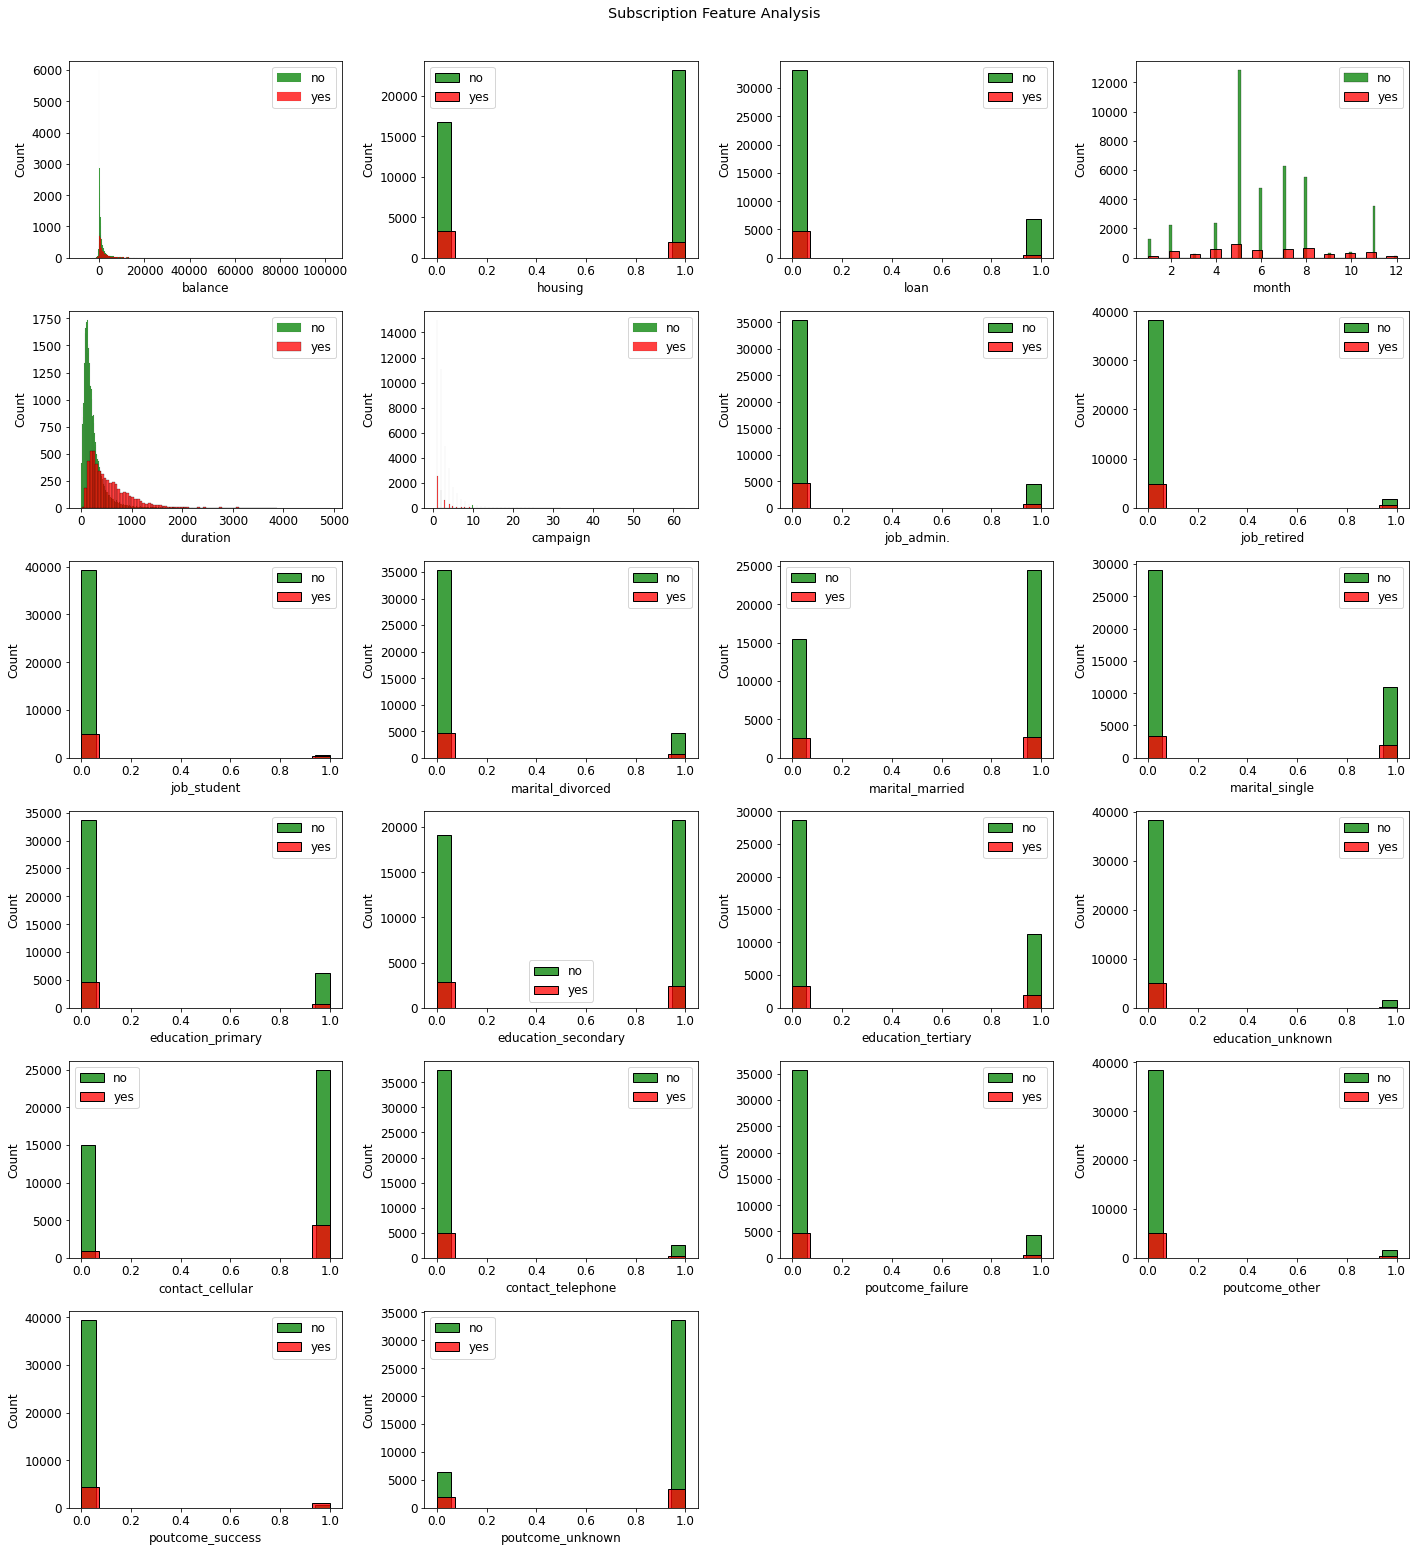

In [146]:
# Visualize the selected features
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(7, 4, j+1)
    j += 1
    sns.histplot(data_red[i][y==0], color='g', label = 'no')
    sns.histplot(data_red[i][y==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Exercise: Cross-validated LASSO feature importance

In [155]:
### START CODE HERE ###
# Instantiate the cross-validated LASSO regressor
reg = LassoCV()
# Train the regressor on the reduced df
reg.fit(data_red, y)
### END CODE HERE ###
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(data_red, y))
coef = pd.Series(reg.coef_, index = data_red.columns)
print(f"Lasso picked {sum(coef != 0)} features and eliminated the other {sum(coef == 0)} features")

Best alpha using built-in LassoCV: 0.059450
Best score using built-in LassoCV: 0.157613
Lasso picked 2 features and eliminated the other 20 features


### Visualize the LASSO feature importances

Text(0.5, 1.0, 'Feature importance using Lasso Model')

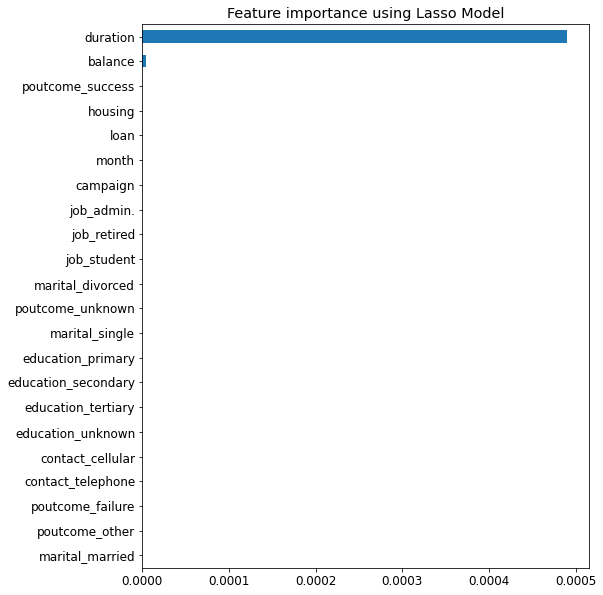

In [156]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
#pdays is the only other feature here

### Print summary statistics for the reduced df

In [157]:
data_red.describe()

,balance,housing,loan,month,duration,campaign,job_admin.,job_retired,job_student,marital_divorced,...,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,1362.272058,0.555838,0.160226,6.144655,258.163080,2.763841,0.114375,0.050076,0.020747,0.115171,...,0.151534,0.513194,0.294198,0.041074,0.647741,0.064276,0.108403,0.040698,0.033421,0.817478
std,3044.765829,0.496878,0.366820,2.408034,257.527812,3.098021,0.318269,0.218105,0.142538,0.319232,...,0.358572,0.499831,0.455687,0.198464,0.477680,0.245247,0.310892,0.197592,0.179735,0.386278
min,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,0.000000,0.000000,5.000000,103.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,448.000000,1.000000,0.000000,6.000000,180.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1428.000000,1.000000,0.000000,8.000000,319.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,102127.000000,1.000000,1.000000,12.000000,4918.000000,63.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Classification

### First, import some convenience functions and perform a 70-30 train-test split split on the (reduced) training data

In [159]:
from sklearn.model_selection import cross_val_score
from numpy import mean
x_train, x_test, y_train, y_test = train_test_split(data_red.values, y, test_size = 0.3)

### Exercise: Default Random Forest Classifier, without balancing

In [177]:
def train_rf(x_train, y_train, max_depth=None, random_state=0, class_weight=None):
    # Instantiate the classifier
    # Set the max depth to 10 and the random state to 0
    clf = RandomForestClassifier(max_depth=max_depth, class_weight=class_weight)
    # Train the classifier
    clf.fit(x_train, y_train)
    return clf

def evaluate_rf(clf, x_test, y_test, cv=5):
    # Use the classifier to make predictions from the test features
    prediction = clf.predict(x_test)
    # Compute the confusion matrix between the true and predicted test targets
    cm = confusion_matrix(y_test, prediction)
    # Compute the model's accuracy by summing the diagonals of the confusion matrix
    # (i.e. taking its trace) and dividing by the number of test samples
    accuracy = np.trace(cm) / len(y_test)
    print(f"Accuracy = {accuracy}")
    recall_scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=cv)
    f1_scores = cross_val_score(clf, x_test, y_test, scoring='f1', cv=cv)
    print(f'Mean Recall = {mean(recall_scores):.3f}')
    print(f'Mean F1 Score = {mean(f1_scores):.3f}')
    print(cm)
    return (accuracy, recall_scores, f1_scores), cm, prediction

In [178]:
clf = train_rf(x_train, y_train)
(accuracy, recall_scores, f1_scores), cm, prediction = evaluate_rf(clf, x_test, y_test)

Accuracy = 0.8992922441757594
Mean Recall = 0.351
Mean F1 Score = 0.454
[[11575   369]
 [  997   623]]


### Exercise: Random Forest Classifier with weight balancing

The target class is highly imbalanced; recall from earlier that only about 11.7% of loan applicants in this dataset are approved. One way around this is to add weight balancing to the classifier.

This exercise is otherwise a repeat of the previous one.

In [179]:
clf = train_rf(x_train, y_train, max_depth=10, class_weight='balanced')
(accuracy, recall_scores, f1_scores), cm, prediction = evaluate_rf(clf, x_test, y_test)

Accuracy = 0.8420082571512828
Mean Recall = 0.760
Mean F1 Score = 0.556
[[10086  1858]
 [  285  1335]]
